## Disclaimer

“The data reported here have been supplied by the United Network for Organ Sharing as the contractor for the Organ Procurement and Transplantation Network. The interpretation and reporting of these data are the responsibility of the author(s) and in no way should be seen as an official policy of or interpretation by the OPTN or the U.S. Government.”

This research was performed based on OPTN data as of July 15, 2021.

## Modeling

After doing data cleaning, EDA, and preprocessing, the last step that remains is to train a model from my data.

For this notebook, I will be testing a few regression machine learning models to come up with a best model for waitlist time prediction for patients in an organ waitlist. First of all, I will be using dummy average as the baseline for my accuracy score. Subsequently, I will employ linear regression model and random forest model. For both models, I will explore the hyperparameters to obtain the best estimator. Finally, I should be able to determine which model is most ideal for my data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('KI_features.csv', index_col='Unnamed: 0')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166404 entries, 5 to 400280
Columns: 160 entries, GENDER to DIAG_KI_3074
dtypes: float64(8), int64(152)
memory usage: 204.4 MB


In [4]:
df.head()

,GENDER,INIT_WGT_KG,INIT_HGT_CM,END_EPTS,INIT_AGE,INIT_BMI_CALC,DISTANCE,DAYSWAIT_CHRON_KI,ratio,ANTIBODY_TESTED_YA,...,DIAG_KI_3063,DIAG_KI_3064,DIAG_KI_3066,DIAG_KI_3068,DIAG_KI_3069,DIAG_KI_3070,DIAG_KI_3071,DIAG_KI_3072,DIAG_KI_3073,DIAG_KI_3074
5,0,0.781752,0.774301,-0.081352,-0.750183,0.380087,-0.245505,184.0,-0.452993,0,...,0,0,0,0,1,0,0,0,0,0
28,1,-1.037128,-0.551874,-0.081352,-1.130134,-0.933057,0.893569,8.0,-0.452993,0,...,0,0,0,0,0,1,0,0,0,0
29,1,-0.914477,-0.054559,-0.081352,-0.306908,-1.123117,0.564042,289.0,-0.769778,0,...,0,0,0,0,1,0,0,0,0,0
48,1,-0.750985,0.111213,-0.081352,-0.876833,-1.019448,-0.442703,478.0,1.300809,0,...,0,0,0,0,1,0,0,0,0,0
57,0,2.028354,0.774301,-0.081352,0.326343,1.848735,-0.455676,3.0,0.282546,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
X = df.drop(columns='DAYSWAIT_CHRON_KI')
y = df.DAYSWAIT_CHRON_KI

In [6]:
print(X.shape)
print(y.shape)

(166404, 159)
(166404,)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=1)

In [8]:
X_train.shape, X_test.shape

((124803, 159), (41601, 159))

In [9]:
y_train.shape, y_test.shape

((124803,), (41601,))

### 1. Dummy Predictor (mean)

In [23]:
from sklearn.dummy import DummyRegressor
dumb = DummyRegressor(strategy='mean')
dumb.fit(X_train, y_train)
dumb.constant_

array([[552.42508594]])

In [25]:
y_pred = dumb.predict(X_test)
y_tr_pred = dumb.predict(X_train)

In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [11]:
def scores(y_test, y_pred):
    print("R\u00b2 : " + str(r2_score(y_test, y_pred)))
    print('RMSE : ' + str(np.sqrt(mean_squared_error(y_test, y_pred))))
    print('MAE : ' + str(mean_absolute_error(y_test, y_pred)))

In [41]:
# Train set
scores(y_train, y_tr_pred)

R² : 0.0
RMSE : 612.0488557970633
MAE : 473.5483690809973


In [42]:
# Test set
scores(y_test, y_pred)

R² : -1.6626326007962433e-05
RMSE : 611.4015226263317
MAE : 471.7979319314357


### 2. Linear Regression

In [62]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
y_tr_pred = lm.predict(X_train)
y_pred = lm.predict(X_test)

In [63]:
# Train set
scores(y_train, y_tr_pred)

R² : 0.13802139547851788
RMSE : 568.2433126708262
MAE : 437.4150125206701


In [64]:
# Test set
scores(y_test, y_pred)

R² : -7820639519136.08
RMSE : 1709794988.1352375
MAE : 8383294.797773205


It seems that the linear model is way worse than the dummy mean predictor. Perhaps there are ways to modify the linear model.

#### Limiting k (number of features)

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression

In [53]:
pipe = make_pipeline(SelectKBest(f_regression), LinearRegression())

In [54]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [56]:
lm_ran_cv = RandomizedSearchCV(pipe,param_distributions=grid_params, cv=5, n_jobs=-1)
lm_ran_cv.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('selectkbest',
                                              SelectKBest(score_func=<function f_regression at 0x7fe31009adc0>)),
                                             ('linearregression',
                                              LinearRegression())]),
                   n_jobs=-1,
                   param_distributions={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7,
                                                           8, 9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, ...]})

In [57]:
lm_ran_cv.best_params_

{'selectkbest__k': 117}

In [59]:
pipe = make_pipeline(SelectKBest(f_regression,k=117), LinearRegression())
pipe.fit(X_train,y_train)
y_tr_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [60]:
# Train set
scores(y_train, y_tr_pred)

R² : 0.11519073986777051
RMSE : 575.7194740378079
MAE : 441.1413230263487


In [61]:
# Test set
scores(y_test, y_pred)

R² : 0.11611761937665699
RMSE : 574.804479521653
MAE : 439.0813358980309


Only using k=117 definitely reduced the error. Still the linear predictor seems to be pretty bad.

#### Elastic Net - Linear model with ridge and Lasso

In [65]:
from sklearn.linear_model import ElasticNet

In [67]:
en=ElasticNet()
grid_params={'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0], 'l1_ratio':np.arange(0, 1, 0.01)}
en_ran_cv = RandomizedSearchCV(en,param_distributions=grid_params, cv=5, n_jobs=-1)
en_ran_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0001, 0.001, 0.01,
                                                  0.1, 0.0, 1.0, 10.0, 100.0],
                                        'l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])})

In [68]:
en_ran_cv.best_params_

{'l1_ratio': 0.84, 'alpha': 0.001}

In [69]:
en_best = ElasticNet(alpha=0.001, l1_ratio=0.84)
en_best.fit(X_train, y_train)
y_tr_pred = en_best.predict(X_train)
y_pred = en_best.predict(X_test)

In [70]:
# Train set
scores(y_train, y_tr_pred)

R² : 0.137889020228253
RMSE : 568.2869439527348
MAE : 437.4581267832327


In [71]:
# Test set
scores(y_test, y_pred)

R² : 0.13743140163428924
RMSE : 567.8318222563344
MAE : 435.8828676658136


It seems that elastic net helped the prediction, but not that much.
If I'm not doing any dimensionality reduction such as PCA, I won't consider linear regression model at all.

### 3. Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(random_state=1,max_depth=3, n_jobs=-1)
RF.fit(X_train,y_train)
y_tr_pred=RF.predict(X_train)
y_pred=RF.predict(X_test)

In [14]:
# Train set
scores(y_train, y_tr_pred)

R² : 0.09033266839984233
RMSE : 583.7506666940285
MAE : 443.0272405148432


In [15]:
# Test set
scores(y_test, y_pred)

R² : 0.09310990496081539
RMSE : 582.2375823731577
MAE : 440.84668933343374


Unfortunately, randomforest is not doing so well.

In [17]:
n_estimators = [10,100,200,500,1000,2000]
RF = RandomForestRegressor(random_state=1, n_jobs=-1)
grid_params={'n_estimators':n_estimators, 'max_depth':[3,4,5]}
RF_cv = RandomizedSearchCV(RF,param_distributions=grid_params, cv=5, n_jobs=-1)
RF_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 2000]})

In [19]:
RF_cv.best_params_

{'n_estimators': 200, 'max_depth': 5}

In [20]:
RF_b = RandomForestRegressor(random_state=1, n_estimators=200, max_depth = 5, n_jobs=-1)
RF_b.fit(X_train,y_train)
y_tr_pred = RF_b.predict(X_train)
y_pred = RF_b.predict(X_test)

In [21]:
# Train set
scores(y_train, y_tr_pred)

R² : 0.13488176720307132
RMSE : 569.2772427241356
MAE : 431.33402430541116


In [22]:
# Test set
scores(y_test, y_pred)

R² : 0.13609775397675716
RMSE : 568.2706250888789
MAE : 429.72148608202605


In [23]:
n_estimators = [100,200,500]
RF = RandomForestRegressor(random_state=1, n_jobs=-1)
grid_params={'n_estimators':n_estimators, 'max_depth':[5,6,7]}
RF_cv = RandomizedSearchCV(RF,param_distributions=grid_params, cv=5, n_jobs=-1)
RF_cv.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 6, 7],
                                        'n_estimators': [100, 200, 500]})

In [24]:
RF_cv.best_params_

{'n_estimators': 500, 'max_depth': 7}

In [25]:
RF_c = RandomForestRegressor(random_state=1, n_estimators=500, max_depth = 7, n_jobs=-1)
RF_c.fit(X_train,y_train)
y_tr_pred = RF_c.predict(X_train)
y_pred = RF_c.predict(X_test)

In [26]:
# Train set
scores(y_train, y_tr_pred)

R² : 0.1909458373938968
RMSE : 550.5222658904034
MAE : 415.29712123750477


In [28]:
# Test set
scores(y_test, y_pred)

R² : 0.1870456942363381
RMSE : 551.2593560313635
MAE : 414.75707775437917


In [32]:
n_estimators = [100,200,500,700]
RF = RandomForestRegressor(random_state=1, n_jobs=-1)
grid_params={'n_estimators':n_estimators, 'max_depth':[7,8,9,10]}
RF_cv = RandomizedSearchCV(RF,param_distributions=grid_params, cv=5, n_jobs=-1)
RF_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [7, 8, 9, 10],
                                        'n_estimators': [100, 200, 500, 700]})

In [33]:
RF_cv.best_params_

{'n_estimators': 700, 'max_depth': 10}

In [34]:
RF_d = RandomForestRegressor(random_state=1, n_estimators=700, max_depth = 10, n_jobs=-1)
RF_d.fit(X_train,y_train)
y_tr_pred = RF_d.predict(X_train)
y_pred = RF_d.predict(X_test)

In [35]:
# Train set
scores(y_train, y_tr_pred)

R² : 0.28654410774064043
RMSE : 516.9751345237248
MAE : 388.335845484251


In [36]:
# Test set
scores(y_test, y_pred)

R² : 0.2651731579991472
RMSE : 524.1015107859769
MAE : 393.3098398503149


As I continue to do random search and modify the randomforest regressor, the $R^2$ value increased from 0.09 to 0.28. I can further search out for better model, but each search takes hours. For healthcare data 0.3 seems to be a good enough relationship. I will be stopping here for now and look into features.

30


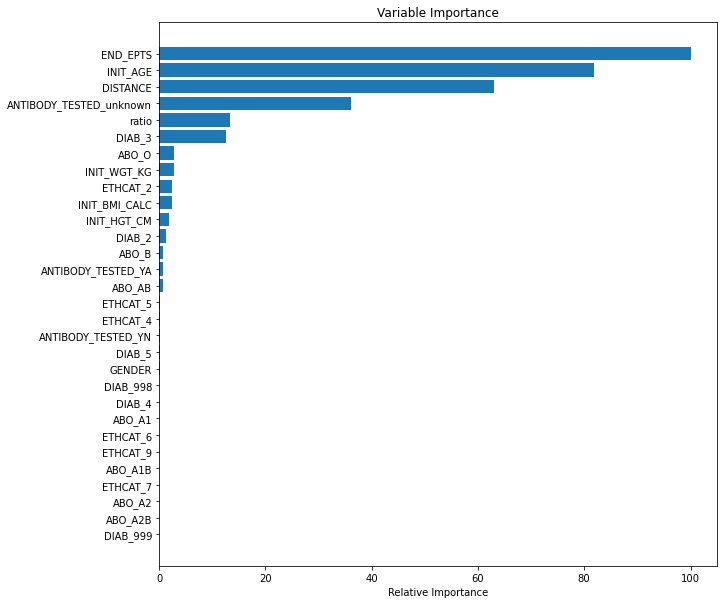

In [37]:
feature_importance = RF_d.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The above graph shows the importance of features in the waitlist days for a patient. For those above 50% importance are 
<br>__END_EPTS__ : calculated survival rate,
<br>__INIT_AGE__ : Age of admission, and 
<br>__DISTANCE__ : distance from donor hospital from treatment center.

Further modifying the Randomforest model will change the feature importance as well, but so far I can conclude that survival rate, age and distance are important features.

### 4. Conclusion

In this notebook, I was able to utilize machine learning algorithms to find the best predictor for the kidney waitlist patients. Overall, the prediction was not very successful. The fact that I'm dealing with healthcare data, and I've reduced the columns from 470 to 15 suggests that I may have missed several important features for my prediction. However, with the random variables in healthcare also complicate my prediction model wich made me accept $R^2$ value of 0.3 as a good enough prediction.

As shown above, the linear models did poorly. In terms of randomforest method, initially the predictor was as bad as linear regression, but as I tuned the hyperparameters, the model improved much. I have stopped due to my computer not being able to handle too much computation, but I can see that there could be much more improvements with continued iterations.

From the predicting model, I was able to conclude that important features to conclude in patient waitlist time is the calculated patient's survival rate, patient's age of admission, and the distance from donor hospital from treatment center. 